In [12]:
# Import Libraries
import pandas as pd
import mlflow

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [13]:
# defining a function to quickly read and prepare data
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    df['hour'] = df.lpep_pickup_datetime.dt.hour
    df['dayofweek'] = df.lpep_pickup_datetime.dt.day_of_week

    categorical = ['PULocationID', 'DOLocationID', 'hour', 'dayofweek', 'VendorID']
    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    return df

In [14]:
# Reading and preparing the dataset
df_train = read_dataframe('/home/ubuntu/data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/home/ubuntu/data/green_tripdata_2021-02.parquet')

In [15]:
# Checking the size of datasets
len(df_train), len(df_val)

(73908, 61921)

In [16]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment-latest")

<Experiment: artifact_location='./mlruns/3', experiment_id='3', lifecycle_stage='active', name='nyc-taxi-experiment-latest', tags={}>

In [17]:
# defing feature types
categorical = ['PU_DO', 'hour', 'dayofweek', 'VendorID'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# applying one hot encoding
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
# defining the target
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
# training the regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.8850389508059076

In [20]:
# training the Lasso model
with mlflow.start_run():

    mlflow.set_tag("developer","nakul")
    mlflow.set_tag("model","lasso")
    mlflow.log_param("train-data-path", "/home/ubuntu/data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "/home/ubuntu/data/green_tripdata_2021-01.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    lasso_pred = lasso.predict(X_val)

    rmse = mean_squared_error(y_val, lasso_pred, squared=False)

    mlflow.log_metric("rmse", rmse)
    mlflow.sklearn.log_model(lasso, artifact_path="model")

    

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [21]:
# training the Ridge Regression model

with mlflow.start_run():

    mlflow.set_tag("developer","nakul")
    mlflow.set_tag("model","ridge")
    mlflow.log_param("train-data-path", "/home/ubuntu/data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "/home/ubuntu/data/green_tripdata_2021-01.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    rid = Ridge(alpha=0.1)
    rid.fit(X_train, y_train)

    rig_pred = rid.predict(X_val)

    rmse = mean_squared_error(y_val, rig_pred, squared=False)

    mlflow.log_metric("rmse", rmse)
    mlflow.sklearn.log_model(rid, artifact_path="model")

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


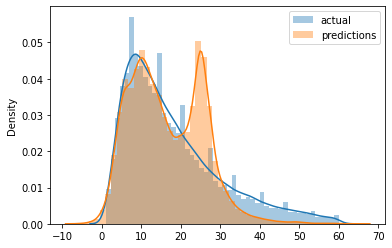

In [22]:
# Plotting actuals vs predictions for top model
sns.distplot(y_val, label = 'actual')
sns.distplot(y_pred, label = 'predictions')

plt.legend()